# Table of content 
* Data Cleansing
  * Removing urls, emojis, and @ABCD.
  * Data Normalization
      * Removing (الهمزة والنقاط من فوق التاء المربوطة).
* Data Preprocessing 
  * Tokenization.
  * Padding.
  * Splitting data to training,test,and validation sets.
* Modeling and training 
  * Define Model architecture
  * Training 
  * Evaluation 
  * Loading Model,and Tokenizer for future use.
  * Test model's predictability 



In [29]:
pip install camel_tools

Note: you may need to restart the kernel to use updated packages.


In [30]:
import pandas as pd 
from camel_tools.utils.normalize import normalize_alef_maksura_ar
from camel_tools.utils.normalize import normalize_alef_ar
from camel_tools.utils.normalize import normalize_teh_marbuta_ar
from camel_tools.tokenizers.word import simple_word_tokenize
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import pickle
%matplotlib inline
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
df=pd.read_csv('../input/nlp-task/dataset.csv',encoding='UTF-32')
df.head()

,id,dialect,text
0,1175358310087892992,IQ,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1,1175416117793349632,IQ,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...
2,1175450108898565888,IQ,@KanaanRema مبين من كلامه خليجي
3,1175471073770573824,IQ,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐
4,1175496913145217024,IQ,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458197 entries, 0 to 458196
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       458197 non-null  int64 
 1   dialect  458197 non-null  object
 2   text     458197 non-null  object
dtypes: int64(1), object(2)
memory usage: 10.5+ MB


No null values.That's great

# Data Cleansing 
* Removing urls, emoji, and twitter usernames.


In [33]:
def text_normalize(text):
    text = normalize_alef_maksura_ar(text)
    text = normalize_alef_ar(text)
    text = normalize_teh_marbuta_ar(text)
    return text

In [34]:
def preprocessing(text):
    """
    The data preprocessing fuction takes string, extracts only arabic text out of it,
    removes الهمزة والتاء المربوطة
    Input >>> text
    Output >>> clean text

    """
    text=re.sub(r'[^\s\u0627-\u064a]','', text)
    text=re.sub(r'(.)\1+', r'\1', text)
    text=text_normalize(text)
    return text

In [35]:
df['text']=df['text'].apply(preprocessing)

In [36]:
df.drop(columns='id',inplace=True)

In [37]:
df.head()

,dialect,text
0,IQ,لكن بالنهايه ينتفض يغير
1,IQ,يعني هذا محسوب علي البشر حيونه وحشيه وتطلبون ...
2,IQ,مبين من كلامه خليجي
3,IQ,يسلملي مرورك وروحك الحلوه
4,IQ,وين هل الغيبه اخ محمد


In [38]:
# get the length of the longest sentence 
max_length=df['text'].str.split(' ').map(len).max()
max_length

86

**Visualizing the number of values of each class**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


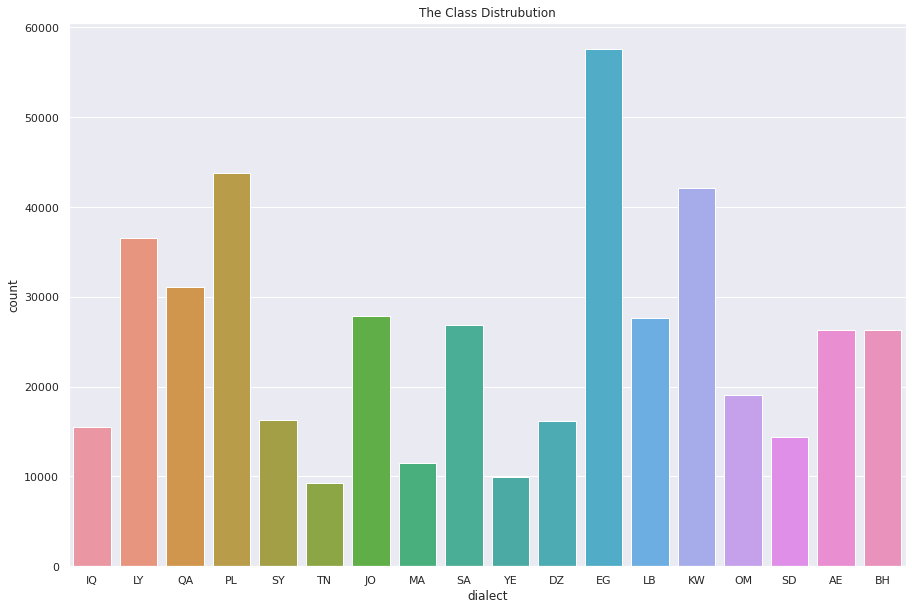

In [39]:
plt.figure(figsize=(15,10));
sns.set_theme(style="darkgrid");
sns.countplot(df['dialect']);
plt.title('The Class Distrubution');


Each class does not contribute equally. Then,The accuracy is not the best metric to use 

# Data Preprocessing

In [40]:
embed_dim = 64
lstm_out = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [41]:
labels=df['dialect']
sentences=df['text']
print('the length of labels is {} '.format(len(labels)))
print('the length of sentences is {} '.format(len(sentences)))

the length of labels is 458197 
the length of sentences is 458197 


In [42]:
x_train,x_test,y_train,y_test=train_test_split(sentences,labels,test_size=0.2, random_state=42)

In [43]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(sentences) 
word_index = tokenizer.word_index
vocab_size=len(word_index)
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

12
86
16
86
9
86


In [44]:
test_sequences = tokenizer.texts_to_sequences(x_test) # YOUR CODE HERE
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length) # YOUR CODE HERE
print(len(test_sequences))
print(test_padded.shape)


91640
(91640, 86)


In [45]:
label_tokenizer = Tokenizer() 
label_tokenizer.fit_on_texts(labels) 

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train)) 
test_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test)) 

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(test_label_seq[0])
print(test_label_seq[1])
print(test_label_seq[2])
print(test_label_seq.shape)

[9]
[7]
[6]
(366557, 1)
[8]
[3]
[11]
(91640, 1)


# Modeling and Training

In [46]:
model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size+1, embed_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(19, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 86, 64)            27370432  
_________________________________________________________________
dropout_3 (Dropout)          (None, 86, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               657408    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 19)               

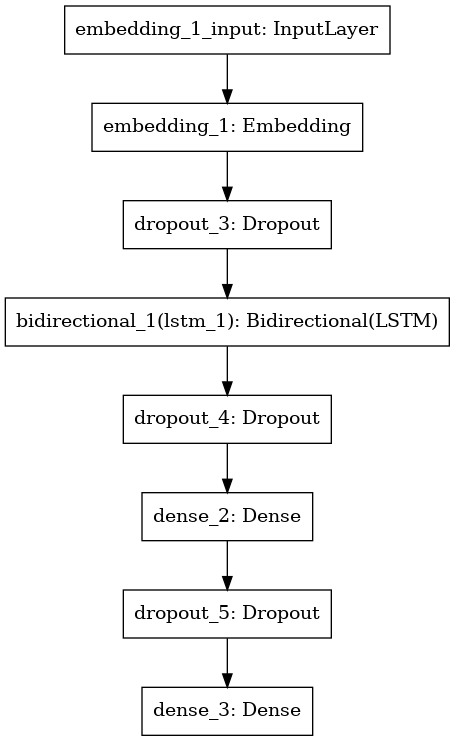

In [47]:
tf.keras.utils.plot_model(
    model, to_file='model.png')

In [48]:
num_epochs = 30
training_padded = np.array(train_padded)
testing_padded = np.array(test_padded)
history = model.fit(training_padded, training_label_seq, epochs=num_epochs, validation_split = 0.3, verbose=2)
print("Training Complete")

Epoch 1/30
8019/8019 - 183s - loss: 2.4944 - accuracy: 0.2134 - val_loss: 2.1846 - val_accuracy: 0.2822
Epoch 2/30
8019/8019 - 181s - loss: 2.2106 - accuracy: 0.2816 - val_loss: 2.0425 - val_accuracy: 0.3225
Epoch 3/30
8019/8019 - 182s - loss: 2.0995 - accuracy: 0.3106 - val_loss: 2.0001 - val_accuracy: 0.3385
Epoch 4/30
8019/8019 - 182s - loss: 2.0291 - accuracy: 0.3313 - val_loss: 1.9753 - val_accuracy: 0.3519
Epoch 5/30
8019/8019 - 182s - loss: 1.9687 - accuracy: 0.3474 - val_loss: 1.9300 - val_accuracy: 0.3587
Epoch 6/30
8019/8019 - 182s - loss: 1.9134 - accuracy: 0.3666 - val_loss: 1.9180 - val_accuracy: 0.3705
Epoch 7/30
8019/8019 - 182s - loss: 1.8638 - accuracy: 0.3854 - val_loss: 1.9034 - val_accuracy: 0.3857
Epoch 8/30
8019/8019 - 182s - loss: 1.8197 - accuracy: 0.4015 - val_loss: 1.9008 - val_accuracy: 0.3965
Epoch 9/30
8019/8019 - 182s - loss: 1.7801 - accuracy: 0.4148 - val_loss: 1.8974 - val_accuracy: 0.4029
Epoch 10/30
8019/8019 - 182s - loss: 1.7427 - accuracy: 0.4280 -

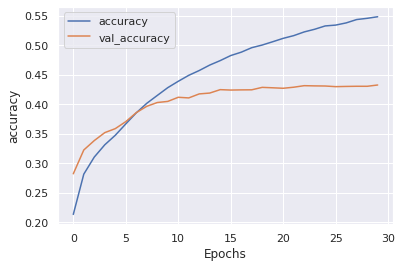

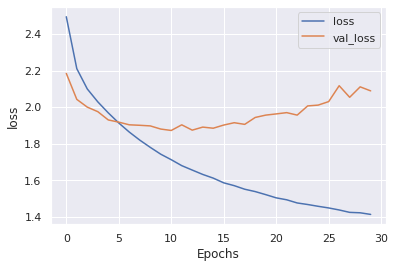

In [49]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

It can be inferred from the above graphs that the model overfits as it is doing good on the training set but not as good in the validation set.

In [50]:
results = model.evaluate(testing_padded, test_label_seq)
results

2864/2864 [==============================] - 18s 6ms/step - loss: 2.1017 - accuracy: 0.4304


[2.101722240447998, 0.4304015636444092]

The model is not that good. It needs some hyperparameter tuning or trying other architecture. However, I will stick to this model in order to submmit the task and beacause I ran out of free GPU.

In [51]:
# save the tokenizer and model. 
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
model_file = "rnn_model.h5"  
model.save( model_file)


In [52]:
with open('tokenizer.pickle', 'rb') as handle:
    token = pickle.load(handle)

In [53]:
#Reverse the label dictionary 
y_id_to_word = {value: key for key, value in label_tokenizer.word_index.items()}
y_id_to_word

{1: 'eg',
 2: 'pl',
 3: 'kw',
 4: 'ly',
 5: 'qa',
 6: 'jo',
 7: 'lb',
 8: 'sa',
 9: 'ae',
 10: 'bh',
 11: 'om',
 12: 'sy',
 13: 'dz',
 14: 'iq',
 15: 'sd',
 16: 'ma',
 17: 'ye',
 18: 'tn'}

**Test Saved Files.**

In [54]:
rnn = tf.keras.models.load_model('./rnn_model.h5')
token = pickle.load(open("./tokenizer.pickle", "rb"))

In [55]:
def predcitor(text):
    """
    this function takes text and returns the dialect
    it normalizes the entered text and use it to predict the dialect.
    """
    max_length=86
    y_id_to_word={1: 'eg',2: 'pl',3: 'kw',4: 'ly',5: 'qa',6: 'jo',7: 'lb',8: 'sa',9: 'ae',10: 'bh',11: 'om',12: 'sy',13: 'dz',14: 'iq',15: 'sd',16: 'ma',17: 'ye',18: 'tn'}
    text=preprocessing(text)
    sentence = [token.word_index[word] for word in text.split()]
    sentence = pad_sequences([sentence], maxlen=max_length, padding='post')
    return y_id_to_word[np.argmax(rnn.predict(sentence)[0])]
    

In [56]:
dialcet=predcitor('انا شايف ان محمد صلاح يفضل في ليفربول')
dialcet

'eg'